# Fine-Tune Whisper For Multilingual ASR with 🤗 Transformers

In this Colab, we present a step-by-step guide on how to fine-tune Whisper
for any multilingual ASR dataset using Hugging Face 🤗 Transformers. This is a
more "hands-on" version of the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper).
For a more in-depth explanation of Whisper, the Common Voice dataset and the theory behind fine-tuning, the reader is advised to refer to the blog post.

## Introduction

Whisper is a pre-trained model for automatic speech recognition (ASR)
published in [September 2022](https://openai.com/blog/whisper/) by the authors
Alec Radford et al. from OpenAI. Unlike many of its predecessors, such as
[Wav2Vec 2.0](https://arxiv.org/abs/2006.11477), which are pre-trained
on un-labelled audio data, Whisper is pre-trained on a vast quantity of
**labelled** audio-transcription data, 680,000 hours to be precise.
This is an order of magnitude more data than the un-labelled audio data used
to train Wav2Vec 2.0 (60,000 hours). What is more, 117,000 hours of this
pre-training data is multilingual ASR data. This results in checkpoints
that can be applied to over 96 languages, many of which are considered
_low-resource_.

When scaled to 680,000 hours of labelled pre-training data, Whisper models
demonstrate a strong ability to generalise to many datasets and domains.
The pre-trained checkpoints achieve competitive results to state-of-the-art
ASR systems, with near 3% word error rate (WER) on the test-clean subset of
LibriSpeech ASR and a new state-of-the-art on TED-LIUM with 4.7% WER (_c.f._
Table 8 of the [Whisper paper](https://cdn.openai.com/papers/whisper.pdf)).
The extensive multilingual ASR knowledge acquired by Whisper during pre-training
can be leveraged for other low-resource languages; through fine-tuning, the
pre-trained checkpoints can be adapted for specific datasets and languages
to further improve upon these results. We'll show just how Whisper can be fine-tuned
for low-resource languages in this Colab.

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

The Whisper checkpoints come in five configurations of varying model sizes.
The smallest four are trained on either English-only or multilingual data.
The largest checkpoints are multilingual only. All 11 of the pre-trained checkpoints
are available on the [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper). The
checkpoints are summarised in the following table with links to the models on the Hub:

| Size     | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


For demonstration purposes, we'll fine-tune the multilingual version of the
[`"small"`](https://huggingface.co/openai/whisper-small) checkpoint with 244M params (~= 1GB).
As for our data, we'll train and evaluate our system on a low-resource language
taken from the [Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)
dataset. We'll show that with as little as 8 hours of fine-tuning data, we can achieve
strong performance in this language.

------------------------------------------------------------------------

\\({}^1\\) The name Whisper follows from the acronym “WSPSR”, which stands for “Web-scale Supervised Pre-training for Speech Recognition”.

## Prepare Environment

First of all, let's try to secure a decent GPU for our Colab! Unfortunately, it's becoming much harder to get access to a good GPU with the free version of Google Colab. However, with Google Colab Pro one should have no issues in being allocated a V100 or P100 GPU.

To get a GPU, click _Runtime_ -> _Change runtime type_, then change _Hardware accelerator_ from _CPU_ to one of the available GPUs, e.g. _T4_ (or better if you have one available). Next, click `Connect T4` in the top right-hand corner of your screen (or `Connect {V100, A100}` if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct  6 00:36:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We'll employ several popular Python packages to fine-tune the Whisper model.
We'll use `datasets[audio]` to download and prepare our training data, alongside
`transformers` and `accelerate` to load and train our Whisper model.
We'll also require the `soundfile` package to pre-process audio files,
`evaluate` and `jiwer` to assess the performance of our model, and
`tensorboard` to log our metrics. Finally, we'll use `gradio` to build a
flashy demo of our fine-tuned model.

In [ ]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires tensorboard~=2.19.0, but you have tensorboard 2.20.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


We strongly advise you to upload model checkpoints directly the [Hugging Face Hub](https://huggingface.co/)
whilst training. The Hub provides:
- Integrated version control: you can be sure that no model checkpoint is lost during training.
- Tensorboard logs: track important metrics over the course of training.
- Model cards: document what a model does and its intended use cases.
- Community: an easy way to share and collaborate with the community!

Linking the notebook to the Hub is straightforward - it simply requires entering your
Hub authentication token when prompted. Find your Hub authentication token [here](https://huggingface.co/settings/tokens):

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load Dataset

Using 🤗 Datasets, downloading and preparing data is extremely simple.
We can download and prepare the Common Voice splits in just one line of code.

First, ensure you have accepted the terms of use on the Hugging Face Hub: [mozilla-foundation/common_voice_11_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0). Once you have accepted the terms, you will have full access to the dataset and be able to download the data locally.

Since Hindi is very low-resource, we'll combine the `train` and `validation`
splits to give approximately 8 hours of training data. We'll use the 4 hours
of `test` data as our held-out test set:

In [ ]:
from datasets import Audio, load_dataset, concatenate_datasets


def load_seanghay(args):
    dataset1 = load_dataset("seanghay/khmer_mpwt_speech")
    dataset1 = dataset1.select_columns(["audio", "transcription"])
    dataset1 = dataset1['train'].cast_column("audio", Audio(sampling_rate=16000))

    dataset2 = load_dataset("seanghay/km-speech-corpus")
    dataset2 = dataset2.select_columns(["audio", "transcription"])
    dataset2 = dataset2['train'].cast_column("audio", Audio(sampling_rate=16000))

    dataset2 = concatenate_datasets([dataset1, dataset2])
    dataset2 = dataset2.shuffle()
    # dataset2 = dataset2.train_test_split(test_size=0.2)
    # train, valid = dataset2['train'], dataset2['test']

    return dataset2

In [ ]:
common_voice = load_seanghay({})

README.md:   0%|          | 0.00/650 [00:00<?, ?B/s]

data/train-00000-of-00005-1bada3bec3702a(…):   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00001-of-00005-fa6cb3f02194fb(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00002-of-00005-a2586de169cd27(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00003-of-00005-64be21c83a7692(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00004-of-00005-b202e3d6bed4b6(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14943 [00:00<?, ? examples/s]

In [ ]:
print(common_voice)

Dataset({
    features: ['audio', 'transcription'],
    num_rows: 17001
})


In [ ]:
from datasets import load_dataset, DatasetDict

#common_voice = DatasetDict()

#common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", "hi", split="train+validation", use_auth_token=True)
#common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", "hi", split="test", use_auth_token=True)

common_voice = load_dataset("seanghay/khmer_mpwt_speech", split="train")
common_voice = common_voice.train_test_split(test_size=0.2, seed=168)

split = common_voice['train'].train_test_split(test_size=0.13, seed=168)
common_voice['train'] = split['train']
common_voice['validation'] = split['test']

print(common_voice)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription', 'raw_transcription'],
        num_rows: 1432
    })
    test: Dataset({
        features: ['audio', 'transcription', 'raw_transcription'],
        num_rows: 412
    })
    validation: Dataset({
        features: ['audio', 'transcription', 'raw_transcription'],
        num_rows: 214
    })
})


Most ASR datasets only provide input audio samples (`audio`) and the
corresponding transcribed text (`sentence`). Common Voice contains additional
metadata information, such as `accent` and `locale`, which we can disregard for ASR.
Keeping the notebook as general as possible, we only consider the input audio and
transcribed text for fine-tuning, discarding the additional metadata information:

In [ ]:
#common_voice = common_voice.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"])
common_voice = common_voice.remove_columns(["raw_transcription"])

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 1432
    })
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 412
    })
    validation: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 214
    })
})


## Prepare Feature Extractor, Tokenizer and Data

The ASR pipeline can be de-composed into three stages:

1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format

In 🤗 Transformers, the Whisper model has an associated feature extractor and tokenizer,
called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)
and [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)
respectively.

We'll go through details for setting-up the feature extractor and tokenizer one-by-one!

### Load WhisperFeatureExtractor

The Whisper feature extractor performs two operations:
1. Pads / truncates the audio inputs to 30s: any audio inputs shorter than 30s are padded to 30s with silence (zeros), and those longer that 30s are truncated to 30s
2. Converts the audio inputs to _log-Mel spectrogram_ input features, a visual representation of the audio and the form of the input expected by the Whisper model

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

We'll load the feature extractor from the pre-trained checkpoint with the default values:

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

### Load WhisperTokenizer

The Whisper model outputs a sequence of _token ids_. The tokenizer maps each of these token ids to their corresponding text string. For Hindi, we can load the pre-trained tokenizer and use it for fine-tuning without any further modifications. We simply have to
specify the target language and the task. These arguments inform the
tokenizer to prefix the language and task tokens to the start of encoded
label sequences:

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Hindi", task="transcribe")

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/494k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

### Combine To Create A WhisperProcessor

To simplify using the feature extractor and tokenizer, we can _wrap_
both into a single `WhisperProcessor` class. This processor object
inherits from the `WhisperFeatureExtractor` and `WhisperProcessor`,
and can be used on the audio inputs and model predictions as required.
In doing so, we only need to keep track of two objects during training:
the `processor` and the `model`:

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="km", task="transcribe")
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer

### Prepare Data

Let's print the first example of the Common Voice dataset to see
what form the data is in:

In [ ]:
!pip install khmer-nltk tha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [khmer-nltk]


In [ ]:
from typing import Dict, List
from khmernltk import word_tokenize
import tha.normalize
import tha.datetime
import tha.decimals
import tha.ordinals
import tha.currency
import tha.repeater


def process_repeater(words: List[str]) -> List[str]:
    fake_tokens = []
    for word in words:
        if word == 'ៗ':
            break
        fake_tokens.append(word)
    if len(fake_tokens) < len(words): # there is repeater
        def fake_tokenizer(_):
            return fake_tokens
        transcription = tha.repeater.processor(' '.join(words), tokenizer=fake_tokenizer)
        words = [word for word in word_tokenize(transcription.replace('▁', ''), return_tokens=True) if word != ' ']
    return words


def transform_khmer_sentence(ds) -> Dict:
    transcription = tha.normalize.processor(ds["transcription"])
    words = [w for w in word_tokenize(transcription, return_tokens=True) if w != " "]
    # check repeater
    old_words = []
    while words != old_words:
        old_words = list(words)
        words = process_repeater(words)
    # standardize numbers and times
    for j in range(len(words)):
        w = words[j]
        if "$" in w or "៛" in w:
            w = tha.currency.processor(w)
        else:
            w = tha.datetime.time_processor(w)
            w = tha.datetime.date_processor(w)
            w = tha.decimals.processor(w)
            w = tha.ordinals.processor(w)
        words[j] = w.replace("▁", " ")

    # retokenize again after standardize
    ll = []
    j = 0
    while j < len(words):
        if words[j] == 'ចិត' and words[j+1] == 'សិប':
            ll.append('ចិតសិប')
            j += 1
        elif words[j] != ' ':
            ll.append(words[j])
        elif words[j] == '?':
            ll[j-1] += '?'
        j += 1
    transcription = " ".join(ll)
    #transcription = word_tokenize(ds["transcription"], return_tokens=False, separator=" ")
    return {"transcription": transcription}

In [ ]:
from khmernltk import word_tokenize
import tha.normalize


def transform_khmer_sentence(ds):
    transcription = tha.normalize.processor(ds["transcription"])
    words = [w for w in word_tokenize(transcription, return_tokens=True) if w != " "]
    transcription = " ".join(words)
    return {"transcription": transcription}

In [ ]:
common_voice = common_voice.map(transform_khmer_sentence, num_proc=2)

In [ ]:
common_voice = common_voice.train_test_split(test_size=0.2, seed=168)

split = common_voice['train'].train_test_split(test_size=0.13, seed=168)
common_voice['train'] = split['train']
common_voice['validation'] = split['test']

print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 11832
    })
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 3401
    })
    validation: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 1768
    })
})


In [ ]:
print(common_voice["train"][0])

Since
our input audio is sampled at 48kHz, we need to _downsample_ it to
16kHz prior to passing it to the Whisper feature extractor, 16kHz being the sampling rate expected by the Whisper model.

We'll set the audio inputs to the correct sampling rate using dataset's
[`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column)
method. This operation does not change the audio in-place,
but rather signals to `datasets` to resample audio samples _on the fly_ the
first time that they are loaded:

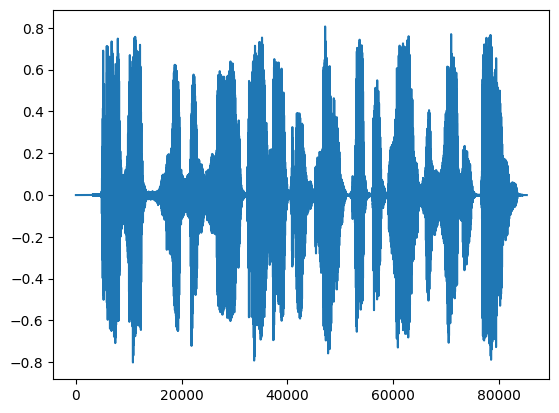

In [ ]:
import matplotlib.pyplot as plt


plt.plot(common_voice["test"][0]["audio"]["array"])

In [ ]:
from IPython.display import Audio

Audio(data=common_voice["test"][0]["audio"]["array"], rate=22600)

In [ ]:
common_voice["test"][0]["audio"]["sampling_rate"]

22050

In [ ]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
from IPython.display import Audio

Audio(data=common_voice["test"][0]["audio"]["array"], rate=16000)

Re-loading the first audio sample in the Common Voice dataset will resample
it to the desired sampling rate:

In [ ]:
print(common_voice["train"][0])

Now we can write a function to prepare our data ready for the model:
1. We load and resample the audio data by calling `batch["audio"]`. As explained above, 🤗 Datasets performs any necessary resampling operations on the fly.
2. We use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array.
3. We encode the transcriptions to label ids through the use of the tokenizer.

In [ ]:
common_voice['test'][0]['transcription']

'ប្រយ័ត្ន មាន ដុំ ថ្ម ក្រាល លើ ទ្រូងផ្លូវ ចាប់ពី ផ្លាក សញ្ញា នេះ ទៅ'

In [ ]:
from khmernltk import word_tokenize


def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    words = [w for w in word_tokenize(batch["transcription"], return_tokens=True) if w != " "]
    transcription = " ".join(words)
    batch["labels"] = tokenizer(transcription).input_ids

    if batch['labels'][-1] != tokenizer.eos_token_id:
        batch['labels'].append(tokenizer.eos_token_id)

    return batch

We can apply the data preparation function to all of our training examples using dataset's `.map` method. The argument `num_proc` specifies how many CPU cores to use. Setting `num_proc` > 1 will enable multiprocessing. If the `.map` method hangs with multiprocessing, set `num_proc=1` and process the dataset sequentially.

In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

Map (num_proc=2):   0%|          | 0/1432 [00:00<?, ? examples/s]

| 2025-10-04 23:30:10,302 | INFO | khmer-nltk | Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |
INFO:khmer-nltk:Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav
| 2025-10-04 23:30:10,426 | INFO | khmer-nltk | Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |
INFO:khmer-nltk:Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav


Map (num_proc=2):   0%|          | 0/412 [00:00<?, ? examples/s]

| 2025-10-04 23:31:21,744 | INFO | khmer-nltk | Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |
INFO:khmer-nltk:Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav
| 2025-10-04 23:31:21,874 | INFO | khmer-nltk | Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |
INFO:khmer-nltk:Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav


Map (num_proc=2):   0%|          | 0/214 [00:00<?, ? examples/s]

| 2025-10-04 23:31:41,995 | INFO | khmer-nltk | Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |
INFO:khmer-nltk:Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav
| 2025-10-04 23:31:41,998 | INFO | khmer-nltk | Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |
INFO:khmer-nltk:Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav


## Training and Evaluation

Now that we've prepared our data, we're ready to dive into the training pipeline.
The [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)
will do much of the heavy lifting for us. All we have to do is:

- Load a pre-trained checkpoint: we need to load a pre-trained checkpoint and configure it correctly for training.

- Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.

- Evaluation metrics: during evaluation, we want to evaluate the model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric. We need to define a `compute_metrics` function that handles this computation.

- Define the training configuration: this will be used by the 🤗 Trainer to define the training schedule.

Once we've fine-tuned the model, we will evaluate it on the test data to verify that we have correctly trained it
to transcribe speech in Hindi.

### Load a Pre-Trained Checkpoint

We'll start our fine-tuning run from the pre-trained Whisper `small` checkpoint,
the weights for which we need to load from the Hugging Face Hub. Again, this
is trivial through use of 🤗 Transformers!

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

We can disable the automatic language detection task performed during inference, and force the model to generate in Hindi. To do so, we set the [langauge](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.language)
and [task](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
arguments to the generation config. We'll also set any [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)
to None, since this was the legacy way of setting the language and
task arguments:

In [ ]:
model.generation_config.language = "km"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None
model.generation_config.suppress_tokens = []
model.generation_config.use_cache = False
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
model.config.use_cache = False

In [ ]:
print(model)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [ ]:
import torch
import torch.nn as nn


class DoRALinear(nn.Module):
    def __init__(self, linear, r, dropout, scale):
        super().__init__()
        self.linear = linear
        self.dropout = nn.Dropout(p=dropout)
        self.scale = scale
        k, d = linear.weight.shape
        self.lora_a = nn.Parameter(torch.Tensor(d, r))
        self.lora_b = nn.Parameter(torch.Tensor(r, k))
        nn.init.zeros_(self.lora_b)
        nn.init.kaiming_uniform_(self.lora_a, nonlinearity='relu')
        self.m = nn.Parameter(torch.Tensor(k))
        with torch.no_grad():
            self.m.copy_(torch.linalg.norm(linear.weight, dim=1))

    def forward(self, x):
        V = self.linear.weight.T
        y = x @ V
        deltaV = self.scale * self.lora_a @ self.lora_b
        z = self.dropout(x) @ deltaV
        Vprime = V + deltaV.detach()
        cNorm = torch.linalg.norm(Vprime.T, dim=1)
        cNorm = cNorm.detach()
        out = (self.m / cNorm) * (y + z)
        if self.linear.bias is not None:
            out += self.linear.bias
        return out

def inject_DoRA(model, r=32, dropout=0.15, scale=1.0):
    for name, child in model.named_children():
        if isinstance(child, nn.Linear):
            if "q_proj" in name or "v_proj" in name or "k_proj" in name or "out_proj" in name:
                setattr(model, name, DoRALinear(child, r, dropout, scale))
        else:
            inject_DoRA(child, r, dropout, scale)

In [ ]:
total_params = sum(p.numel() for p in model.parameters()) / 1e6
for p in model.parameters():
    p.requires_grad = False
inject_DoRA(model, r=4, dropout=0.0, scale=20.0)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(num_params, total_params)

0.995328 241.734912


In [ ]:
class LoRAConv1d(nn.Module):
    def __init__(self, conv, r, scale):
        super().__init__()
        self.conv = conv
        self.scale = scale
        cout, cin, k = conv.weight.shape
        self.lora_a = nn.Parameter(torch.Tensor(cin * k, r * k))
        self.lora_b = nn.Parameter(torch.Tensor(r * k, cout))
        nn.init.zeros_(self.lora_b)
        nn.init.kaiming_uniform_(self.lora_a, nonlinearity='relu')

    @property
    def stride(self):
        return self.conv.stride

    def forward(self, x):
        deltaW = self.scale * self.lora_a @ self.lora_b
        deltaW = deltaW.view(self.conv.weight.shape)
        return self.conv._conv_forward(
            x,
            self.conv.weight + deltaW,
            self.conv.bias
        )

def inject_LoRAConv1d(model, r=4, scale=1.0):
    for name, child in model.named_children():
        if isinstance(child, nn.Conv1d):
            setattr(model, name, LoRAConv1d(child, r, scale))
        else:
            inject_LoRAConv1d(child, r, scale)

In [ ]:
inject_LoRAConv1d(model, r=4, scale=1.0)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print(num_params, total_params)

1.044288 241.734912


In [ ]:
print(model)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): LoRAConv1d(
        (conv): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (conv2): LoRAConv1d(
        (conv): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      )
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): DoRALinear(
              (linear): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (v_proj): DoRALinear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (q_proj): DoRALinear(
              (linear): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
  

### Define a Data Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it
treats the `input_features` and `labels` independently: the  `input_features` must be
handled by the feature extractor and the `labels` by the tokenizer.

The `input_features` are already padded to 30s and converted to a log-Mel spectrogram
of fixed dimension by action of the feature extractor, so all we have to do is convert the `input_features`
to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`.

The `labels` on the other hand are un-padded. We first pad the sequences
to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens
are then replaced by `-100` so that these tokens are **not** taken into account when
computing the loss. We then cut the BOS token from the start of the label sequence as we
append it later during training.

We can leverage the `WhisperProcessor` we defined earlier to perform both the
feature extractor and the tokenizer operations:

In [ ]:
common_voice = common_voice.rename_columns({'audio': 'input_features', 'transcription': 'labels'})

In [ ]:
# WARNING: this cell is a draft code only
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union
from khmernltk import word_tokenize

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, batch) -> Dict[str, torch.Tensor]:
        #features = []
        input_features = []
        label_features = []
        for b in batch:
            #data = {}
            # load and resample audio data from 48 to 16kHz
            audio = b["input_features"]

            # compute log-Mel input features from input audio array
            # data["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
            input_feat = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
            input_features.append({"input_features": input_feat})

            # encode target text to label ids
            #words = [w for w in word_tokenize(b["labels"], return_tokens=True) if w != " "]
            #transcription = " ".join(words)
            #data["labels"] = tokenizer(transcription).input_ids
            #if data['labels'][-1] != tokenizer.eos_token_id:
            #    data['labels'].append(tokenizer.eos_token_id)

            labels = tokenizer(b["labels"]).input_ids

            if labels[-1] != tokenizer.eos_token_id:
                labels.append(tokenizer.eos_token_id)
            label_features.append({"input_ids": labels})
            # features.append(data)


        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        #input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        #label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union
from khmernltk import word_tokenize

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, batch) -> Dict[str, torch.Tensor]:
        audio_arrays = [b['input_features']['array'] for b in batch]
        transcriptions = [b['labels'] for b in batch]

        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        batch = feature_extractor(audio_arrays, return_tensors="pt", sampling_rate=16000)

        # get the tokenized label sequences
        # pad the labels to max length
        labels_batch = tokenizer(transcriptions, return_tensors="pt", pad_to_multiple_of=8, padding=True)

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined:

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

In [ ]:
import evaluate

metric = evaluate.load("wer")

We then simply have to define a function that takes our model
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    print("pred:", pred_str[0])
    print("true:", label_str[0])

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    # output_dir="./whisper-small-hi",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=1000,
    gradient_checkpointing=False,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=250,
    eval_steps=250,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    #push_to_hub=True,
    #hub_model_id=""
)

**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`.

We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=feature_extractor,
)

We'll save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

In [ ]:
processor.save_pretrained(training_args.output_dir)

[]

### Training

Training will take approximately 5-10 hours depending on your GPU or the one
allocated to this Google Colab. If using this Google Colab directly to
fine-tune a Whisper model, you should make sure that training isn't
interrupted due to inactivity. A simple workaround to prevent this is
to paste the following code into the console of this tab (_right mouse click_
-> _inspect_ -> _Console tab_ -> _insert code_).

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton, 60000);
```

The peak GPU memory for the given training configuration is approximately 15.8GB.
Depending on the GPU allocated to the Google Colab, it is possible that you will encounter a CUDA `"out-of-memory"` error when you launch training.
In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2
and employ [`gradient_accumulation_steps`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments.gradient_accumulation_steps)
to compensate.

To launch training, simply execute:

In [ ]:
trainer.train()

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Wer
250,0.814400,0.852956,160.000000
500,0.484700,0.492915,95.718157
750,0.200400,0.382697,91.327913
1000,0.121200,0.329446,89.810298


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


pred: ភាព គ្ងង គ្នាក់ គ្នាក់
true: ភាព កោង ឬ វៀច


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


pred: ភាលង កង់ រវា
true: ភាព កោង ឬ វៀច
pred:  ហាបក កោង រួច វិច ១០ម៉ែត្រ
true: ភាព កោង ឬ វៀច
pred:  គងង់ រអាច
true: ភាព កោង ឬ វៀច


There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=1000, training_loss=0.6616297731399536, metrics={'train_runtime': 5138.8203, 'train_samples_per_second': 1.557, 'train_steps_per_second': 0.195, 'total_flos': 2.33146957824e+18, 'train_loss': 0.6616297731399536, 'epoch': 5.58659217877095})

Our best WER is 32.0% - not bad for 8h of training data! We can make our model more accessible on the Hub with appropriate tags and README information.
You can change these values to match your dataset, language and model
name accordingly:

In [ ]:
trainer.evaluate(eval_dataset=common_voice['test'])

In [ ]:
kwargs = {
    #"dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset_tags": "seanghay/khmer_mpwt_speech",
    "dataset": "seanghay/khmer_mpwt_speech",  # a 'pretty' name for the training dataset
    "dataset_args": "config: km, split: test",
    "language": "km",
    "model_name": "Whisper Small Kh - Sanchit Gandhi",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command and save the preprocessor object we created:

In [ ]:
trainer.push_to_hub(**kwargs)

## Building a Demo

Now that we've fine-tuned our model we can build a demo to show
off its ASR capabilities! We'll make use of 🤗 Transformers
`pipeline`, which will take care of the entire ASR pipeline,
right from pre-processing the audio inputs to decoding the
model predictions.

Running the example below will generate a Gradio demo where we
can record speech through the microphone of our computer and input it to
our fine-tuned Whisper model to transcribe the corresponding text:

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="sanchit-gandhi/whisper-small-hi")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs="text",
    title="Whisper Small Hindi",
    description="Realtime demo for Hindi speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()

## Closing Remarks

In this blog, we covered a step-by-step guide on fine-tuning Whisper for multilingual ASR
using 🤗 Datasets, Transformers and the Hugging Face Hub. For more details on the Whisper model, the Common Voice dataset and the theory behind fine-tuning, refere to the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper). If you're interested in fine-tuning other
Transformers models, both for English and multilingual ASR, be sure to check out the
examples scripts at [examples/pytorch/speech-recognition](https://github.com/huggingface/transformers/tree/main/examples/pytorch/speech-recognition).